In [1]:
import sys
sys.path.append('./')
import utils
import json
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multitest import fdrcorrection

from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 20, 
      'axes.titlesize': 20, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("ticks")

mpl.rcParams['xtick.labelsize'] = 23
mpl.rcParams['ytick.labelsize'] = 23 
mpl.rcParams['legend.fontsize'] = 20

# load stuff:
res = pd.read_csv('../data/master_table.tsv', sep='\t', index_col=0)
# keep DE genes only:
res = res[((res.padj58 < 0.05) | (res.padj50 < 0.05)) & (res.Sign == 'Same')] 

cols = ['externalgenename', 'log2FoldChange{0}', 'padj{0}']
fetch = lambda x: [c.format(x) for c in cols]
rename = lambda x: {'log2FoldChange{0}'.format(x): 'log2FoldChange', 'padj{0}'.format(x): 'padj'}

# data wrangling to create a new dataframe that contains the `results` data, but will also include
# the tissue annotations
a = res[fetch('58')].rename(columns=rename('58'))
b = res[fetch('50')].rename(columns=rename('50'))
a['data'] = '58'
b['data'] = '50'
annotated_data = pd.concat([a[a.padj < 0.05], b[b.padj < 0.05]])
cat_type = pd.CategoricalDtype(categories=['50', '58'], ordered=True)
annotated_data.data = annotated_data.data.astype(cat_type)

# load tissue dictionary:
tissues = utils.load_tissues(res.index, 5, 30)
annotated_data = annotated_data.join(tissues.set_index('wbid')).dropna(subset=['tissue'])
annotated_data.head()

tissues originally: 1535
tissues afterwards: 264


,externalgenename,log2FoldChange,padj,data,external_gene_name,target_id,species,tissue
WBGene00000001,aap-1,0.096256,0.009407,58,aap-1,Y110A7A.10,Caenorhabditis elegans,body wall musculature
WBGene00000001,aap-1,0.096256,0.009407,58,aap-1,Y110A7A.10,Caenorhabditis elegans,hypodermis
WBGene00000001,aap-1,0.096256,0.009407,58,aap-1,Y110A7A.10,Caenorhabditis elegans,intestine
WBGene00000001,aap-1,0.096256,0.009407,58,aap-1,Y110A7A.10,Caenorhabditis elegans,neuron
WBGene00000023,abt-5,-0.342206,0.000949,50,abt-5,Y53C10A.9,Caenorhabditis elegans,head


In [2]:
# perform a binomial test for change in direction:
alpha = 0.05
data = utils.test_tissue_direction(res[res.padj58 < 0.05], tissues)
data_50 = utils.test_tissue_direction(res[res.padj50 < 0.05], tissues, col='log2FoldChange50')

data = pd.concat([data, data_50], keys=['58', '50']
                ).reset_index().rename(
                columns={'level_0': 'data'}
                ).drop('level_1', axis=1)

data = utils.fdr_correct(data)
data.sort_values('fdr', inplace=True)

data['MeanFracPos'] = data.groupby(['tissue', 'data']).FracPos.transform(np.mean)
data['MeanFracPos'] = data.groupby(['tissue', 'data']).FracPos.transform(np.mean)

# keep only significant results:
keep = data.groupby('tissue').sig.sum()
data = data[data.tissue.isin(keep[keep > 0].index)]

m = 'There were {0} tissues that changed more in one direction than expected by random chance in dataset {1}'
for n, g in data.groupby('data'):
    print(m.format(len(g), n))

There were 47 tissues that changed more in one direction than expected by random chance in dataset 50
There were 53 tissues that changed more in one direction than expected by random chance in dataset 58


In [3]:
jaccard = []
remove = ['Cell', 'tail', 'head', 'male gonad', 'gonad', ]  # so broad. why ever have these terms...
for i, t in enumerate(data.tissue.unique()):
    for t2 in data.tissue.unique()[i + 1:]:
        if t == t2:
            continue
        current = tissues.tissue.isin([t, t2])
        counted = tissues[current].groupby('wbid').tissue.count() 
        both = (counted == 2).sum()
        min_size = tissues[current].groupby('tissue').wbid.count().min()
        min_tissue = tissues[current].groupby('tissue').wbid.count().idxmin()

        if (both / min_size > 0.75) & (min_tissue!= 'pharynx'):
            remove += [min_tissue]

In [4]:
print('The following list of tissues will be removed from the plot', list(set(remove)))

The following list of tissues will be removed from the plot ['phasmid neuron', 'ABp', 'posterior distal tip cell', 'anal depressor muscle', 'Z3', 'hyp9', 'hypodermis', 'EMS', 'gonad', 'tail', 'vulval muscle', 'hermaphrodite gonad', 'tail neuron', 'AB', 'hyp11', 'excretory cell', 'mu-int-R', 'hyp8', 'head', 'reproductive system', 'Z2', 'male gonad', 'rectal epithelium', 'nervous system', 'body region', 'anterior distal tip cell', 'ABa', 'virL', 'hyp12', 'mu-int-L', 'Cell', 'P0', 'Psub2', 'Psub1', 'ventral cord neuron']


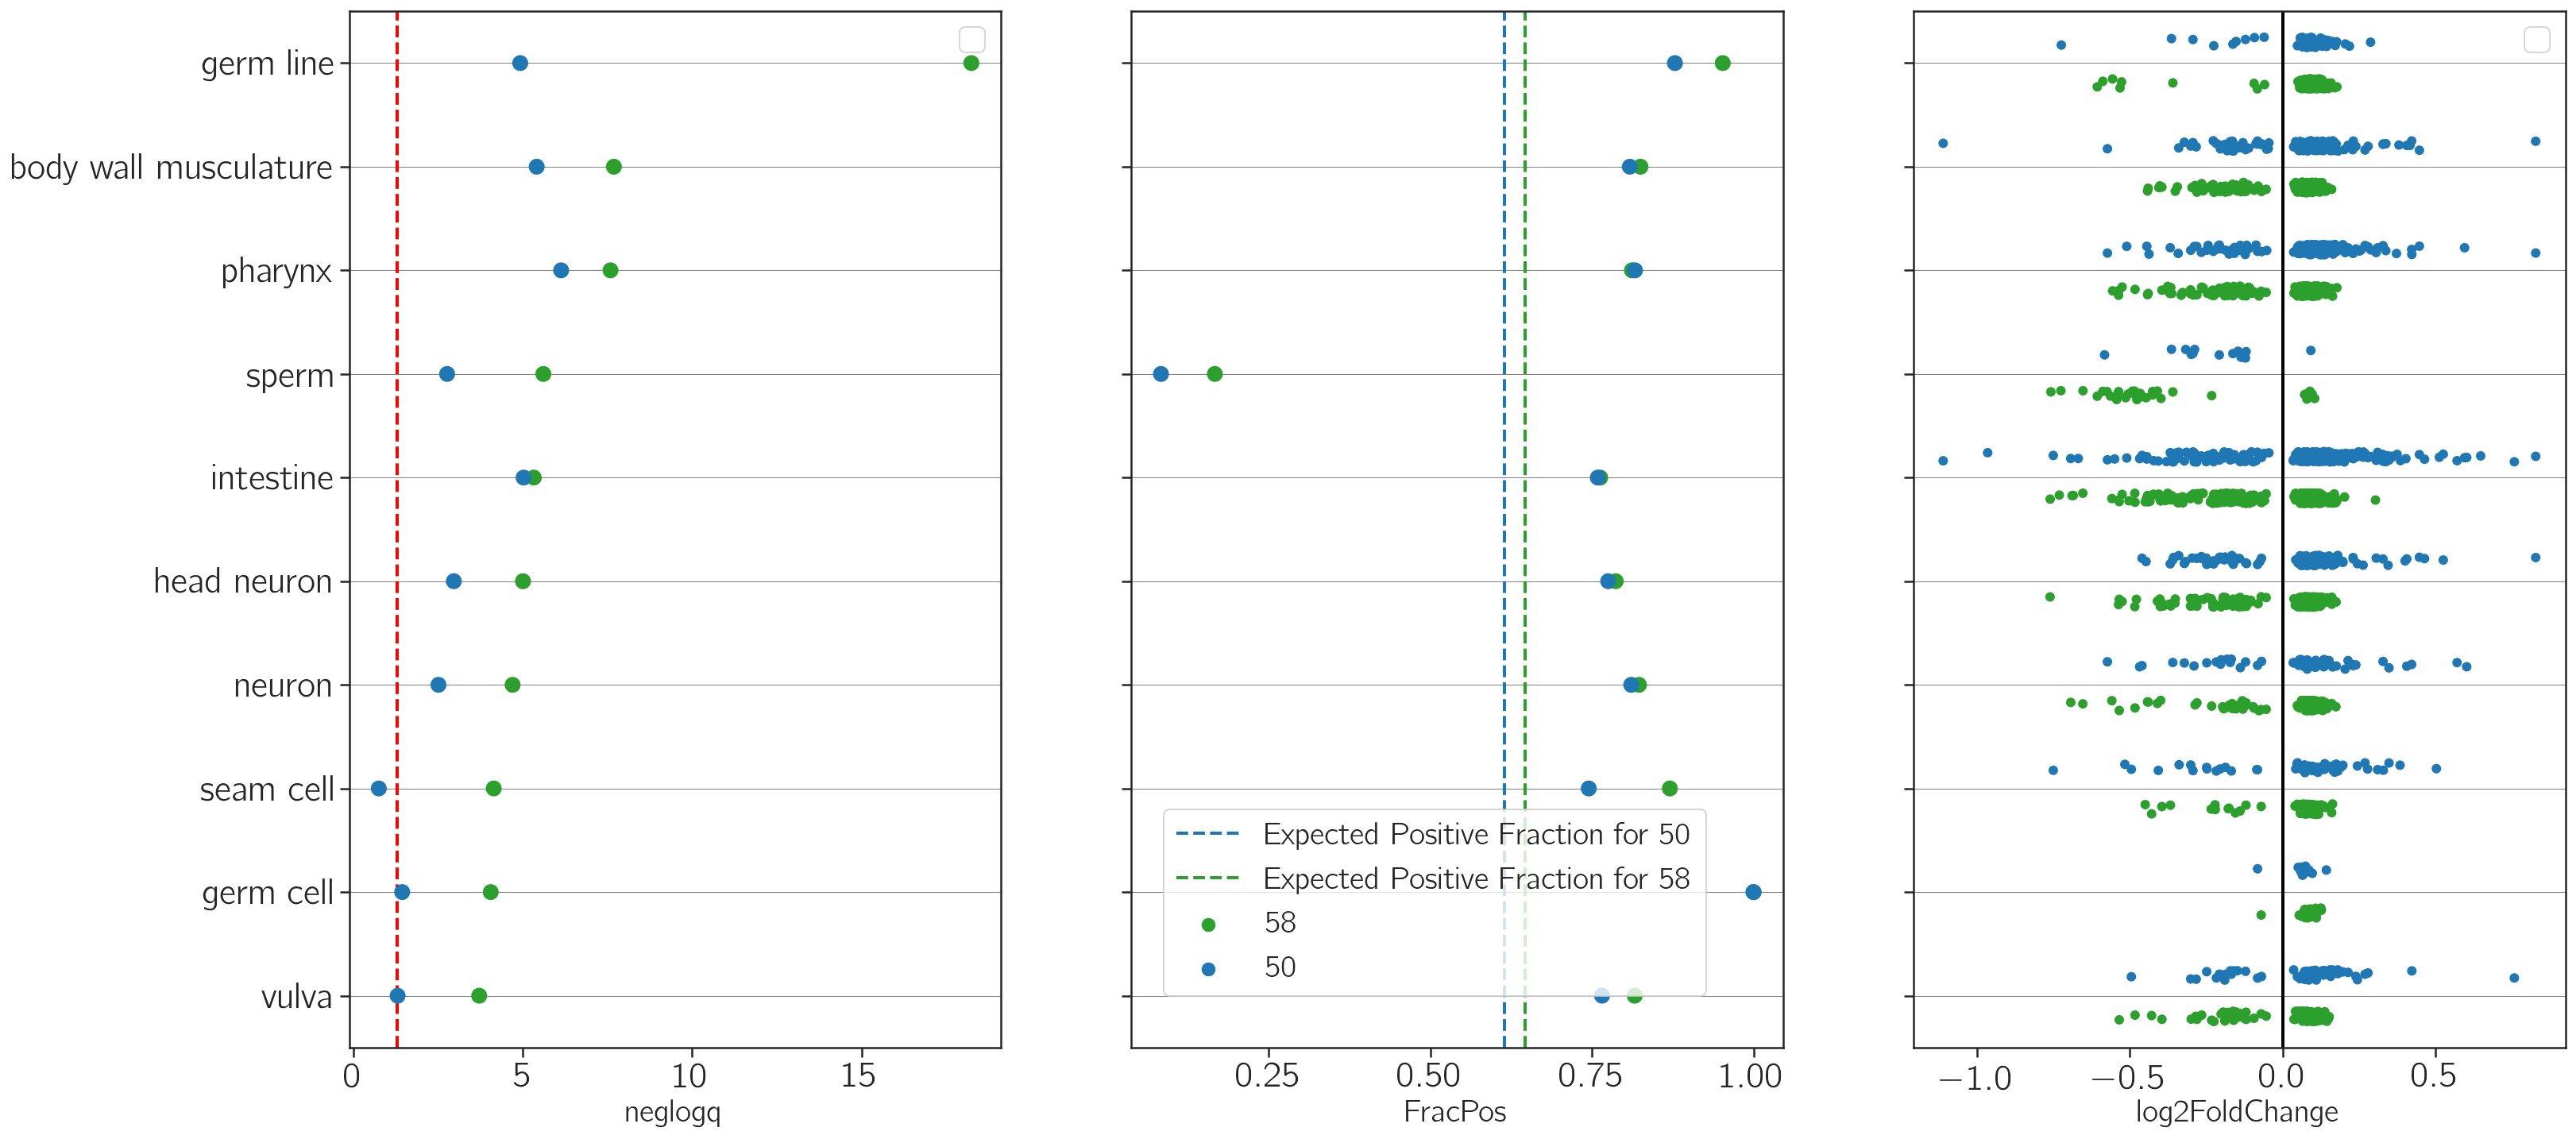

In [5]:
to_plot = data[(~data.tissue.isin(remove)) & (data.sig == True)].head(15)#.sort_values('fdr').head(10)
to_plot = data[(data.tissue.isin(to_plot.tissue))]

tissues_plotted = to_plot.tissue.unique()
fig, ax = utils.pretty_GSEA_plots(to_plot, annotated_data, alpha)

plt.savefig('../figs/tissue_GSEA.svg', bbox_inches='tight', transparent=True)

In [6]:
res = pd.read_csv('../data/diff_exp/DE_pqm1_50.csv', index_col=0)
res = res[(res.padj < 0.05)] #& (res.MinCountsDetected > 20)]

tissues = utils.load_tissues(res.index, 5, 30)
res = res.reindex(tissues.wbid.unique()).dropna()

alpha = 0.05
data = utils.test_tissue_direction(res[res.padj < 0.05],
                                   tissues=tissues,
                                   col='log2FoldChange')
data = utils.fdr_correct(data)
data.sort_values('fdr', inplace=True)

data['MeanFracPos'] = data.groupby('tissue').FracPos.transform(np.mean)

m = 'There were {0} tissues that changed more in one direction than expected by random chance in dataset {1}'
print(m.format(len(data[data.sig == True]), n))

tissues originally: 2132
tissues afterwards: 737


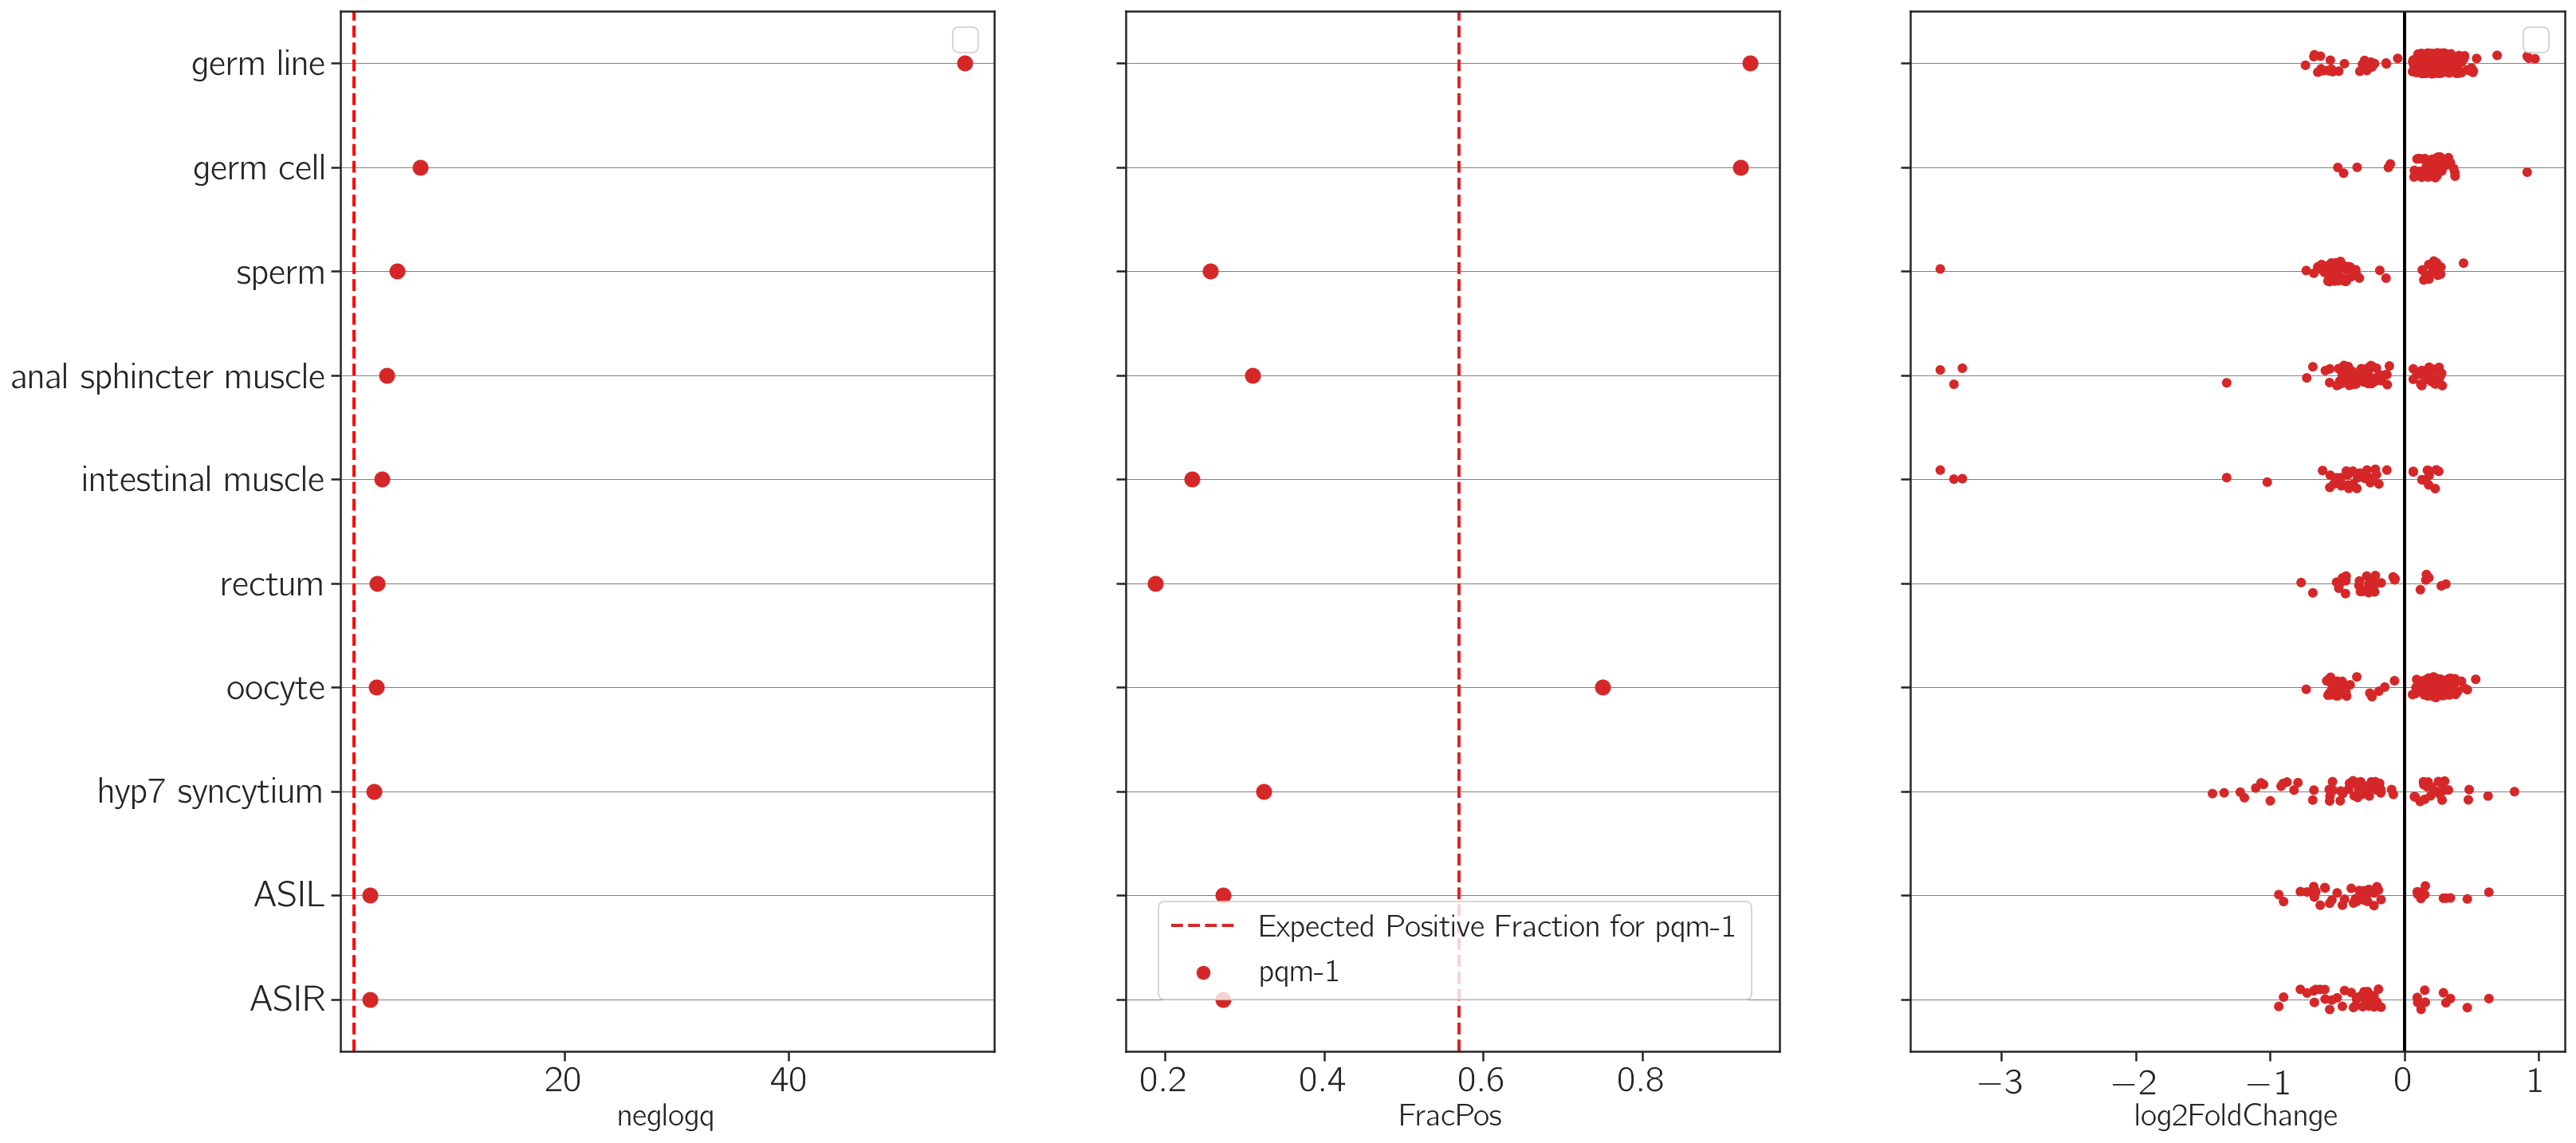

In [8]:
data['data'] = 'pqm-1'
to_plot = data[(~data.tissue.isin(remove)) & (data.sig == True)].head(10)#.sort_values('fdr').head(10)
annotated_data = res.join(tissues.set_index('wbid'))
annotated_data['data'] = 'pqm-1'
# tissues_plotted = to_plot.tissue.unique()

fig, ax = utils.pretty_GSEA_plots(to_plot, annotated_data, alpha, hue='data', palette={'pqm-1': 'tab:red'})

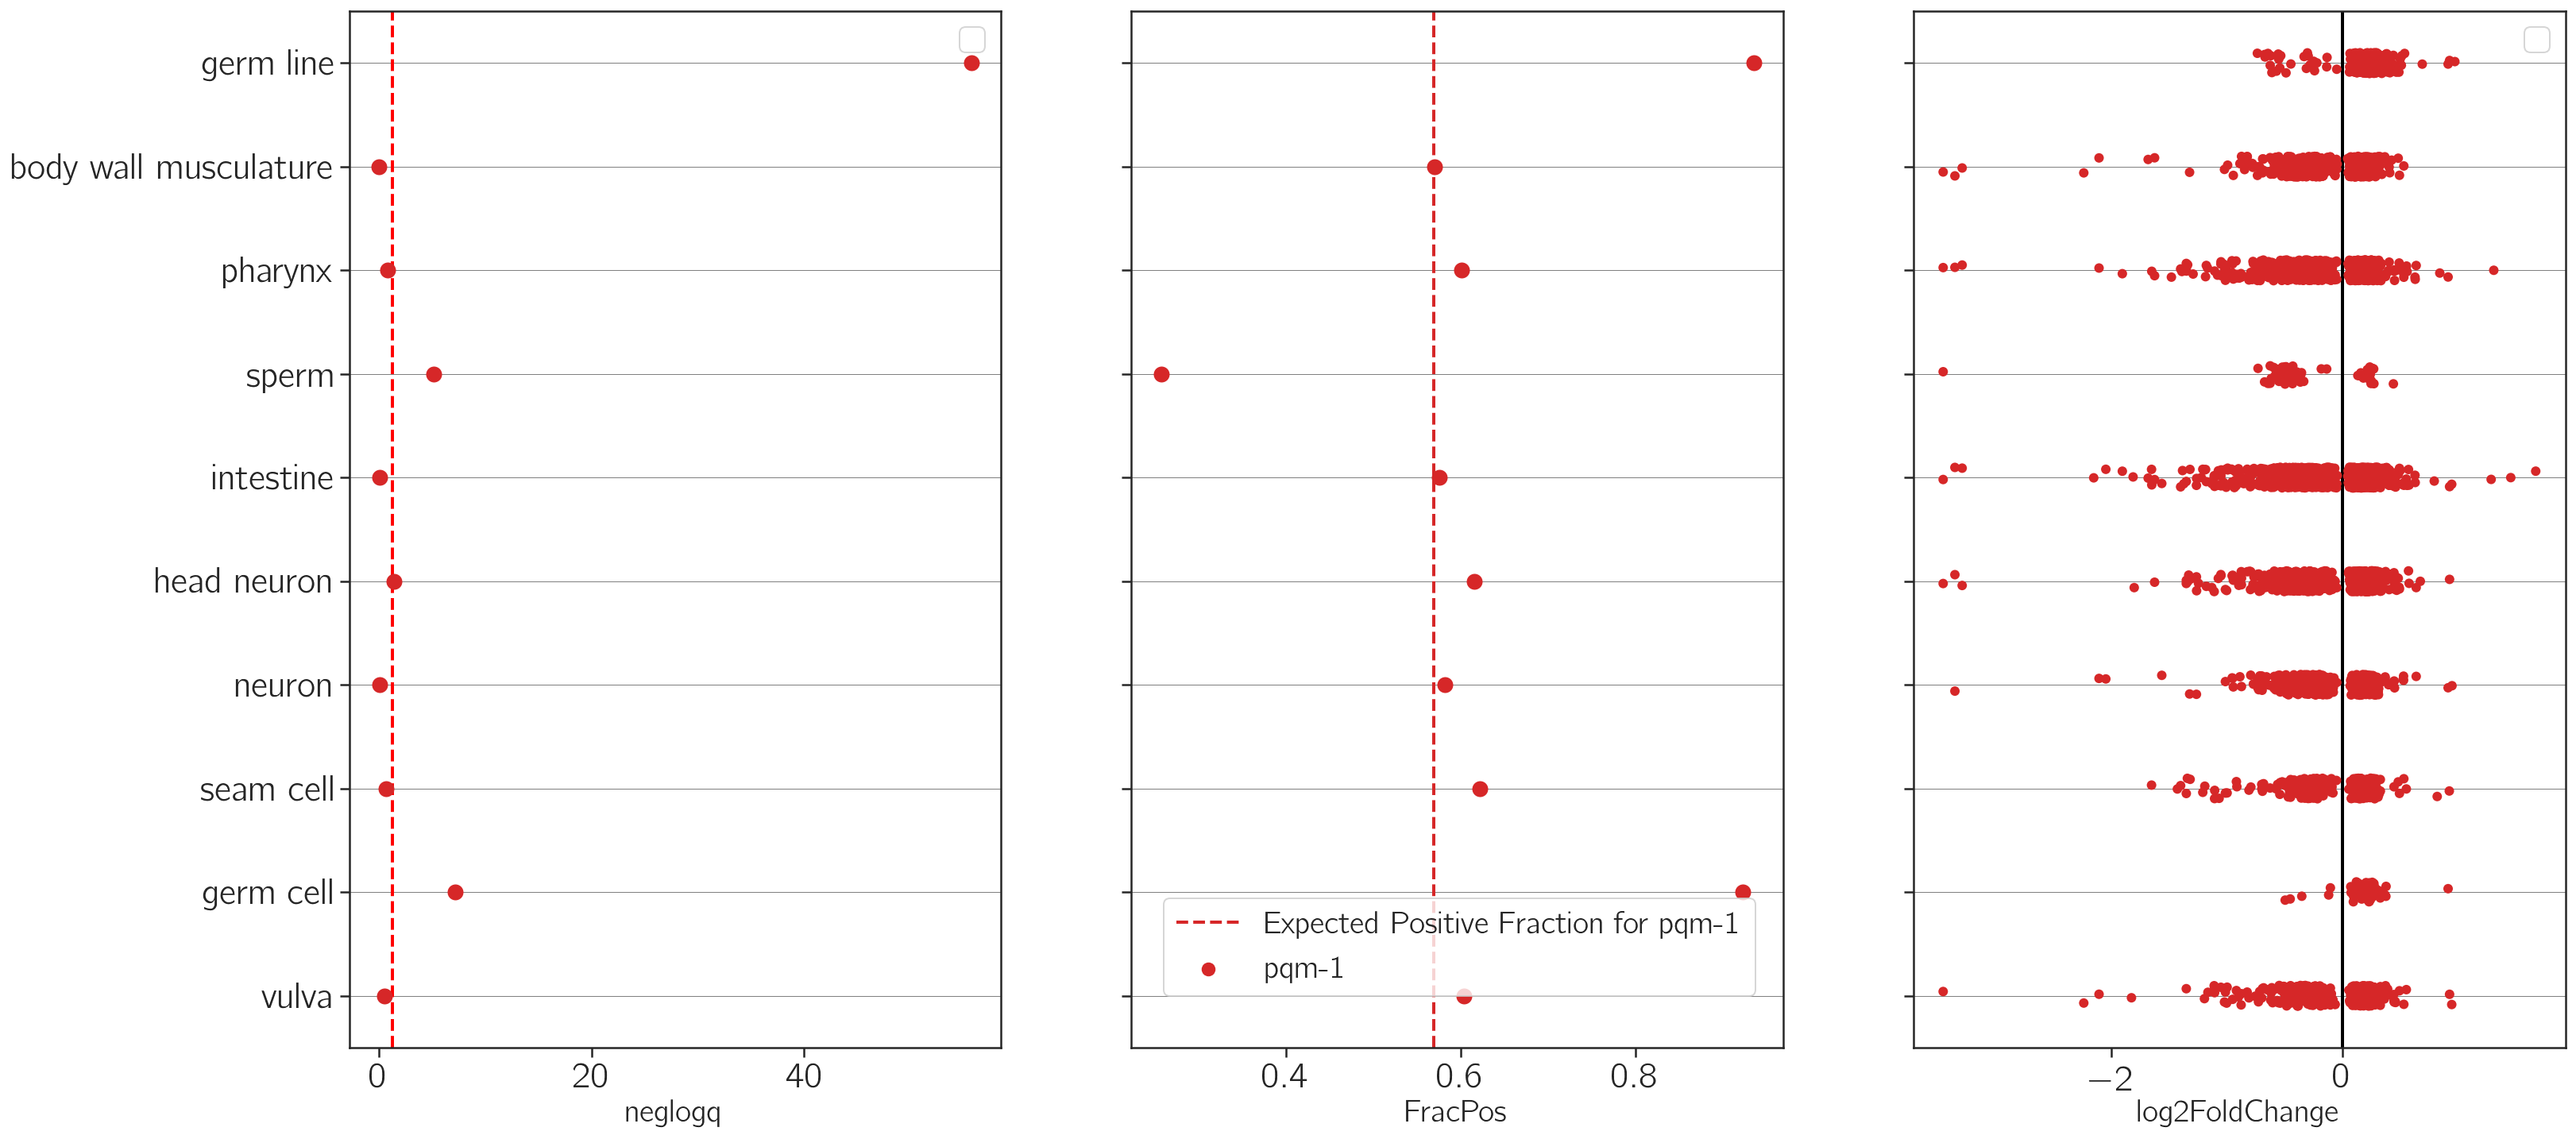

In [9]:
to_plot = data[(~data.tissue.isin(remove)) & (data.tissue.isin(tissues_plotted))].copy()
to_plot.tissue = to_plot.tissue.astype('category')
to_plot.tissue.cat.set_categories(tissues_plotted, inplace=True)
to_plot.sort_values('tissue', inplace=True)

fig, ax = utils.pretty_GSEA_plots(to_plot, annotated_data, alpha, hue='data', palette={'pqm-1': 'tab:red'})